<a href="https://colab.research.google.com/github/vikiysr/mlprojects/blob/main/sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Problem Statement

i. You are provided with historical sales data for 45 retail stores located in
different regions. Each store contains a number of departments, and you are
tasked with predicting the department-wide sales for each store.
ii. In addition, the retail company runs several promotional markdown events
throughout the year. These markdowns precede prominent holidays, the four
largest of which are the Super Bowl, Labour Day, Thanksgiving, and
Christmas.
iii. Data:
1. stores.csv: This file contains anonymized information about the 45
stores, indicating the type and size of the store.
2. features.csv: Comprise of information on Markdown and
macroeconomic factors.
3. train.csv: This is the historical training data.

##Importing the Libraries and dependencies

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2.Data Collection

Loading the features dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Data/Sales Forecasting/train.csv')
features_df = pd.read_csv('/content/drive/MyDrive/Data/Sales Forecasting/features.csv')
df = pd.merge(df, features_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date'])
stores_df = pd.read_csv('/content/drive/MyDrive/Data/Sales Forecasting/stores.csv')
df = pd.merge(df, stores_df, how = 'left', on = ['Store'])
df.shape

(421570, 16)

In [6]:
test = pd.read_csv('/content/drive/MyDrive/Data/Sales Forecasting/test.csv')
test = pd.merge(test, features_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date'])
test = pd.merge(test, stores_df, how = 'left', on = ['Store'])
test.shape

(115064, 15)

In [7]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [8]:
test.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size'],
      dtype='object')

#3.Exploratory Data Analysis

Store-type wise pie chart

  Type  Store
0    A     22
1    B     17
2    C      6


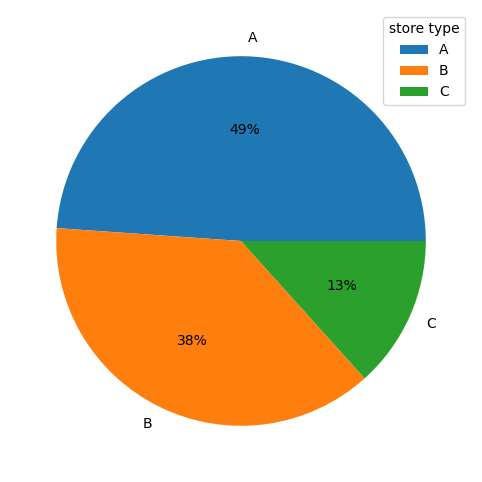

In [9]:
temp = pd.DataFrame(df.groupby('Type')['Store'].nunique()).reset_index()
print(temp)
plt.figure(figsize = (12,6))
plt.pie(temp['Store'], labels = temp['Type'],autopct = '%.0f%%')
plt.legend(title="store type")
plt.show()


In [10]:
#Type A stores acquire half percent of the total number of stores

Size distribution of stores for each store type

<Axes: xlabel='Type', ylabel='Size'>

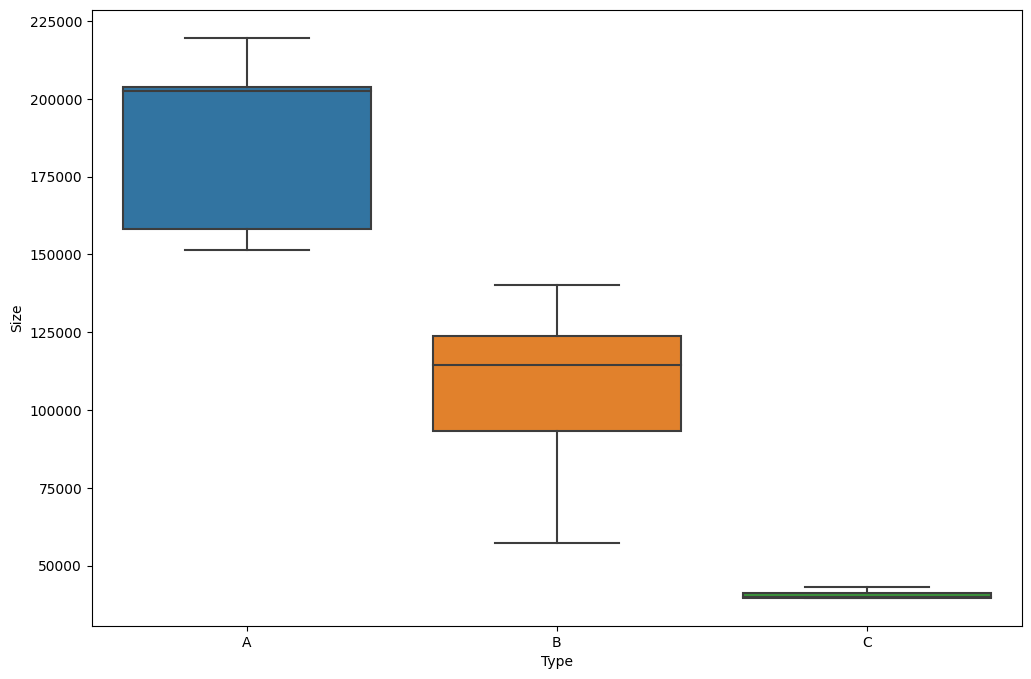

In [11]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)

Distribution of weekly sales based on store type

<Axes: xlabel='Type', ylabel='Weekly_Sales'>

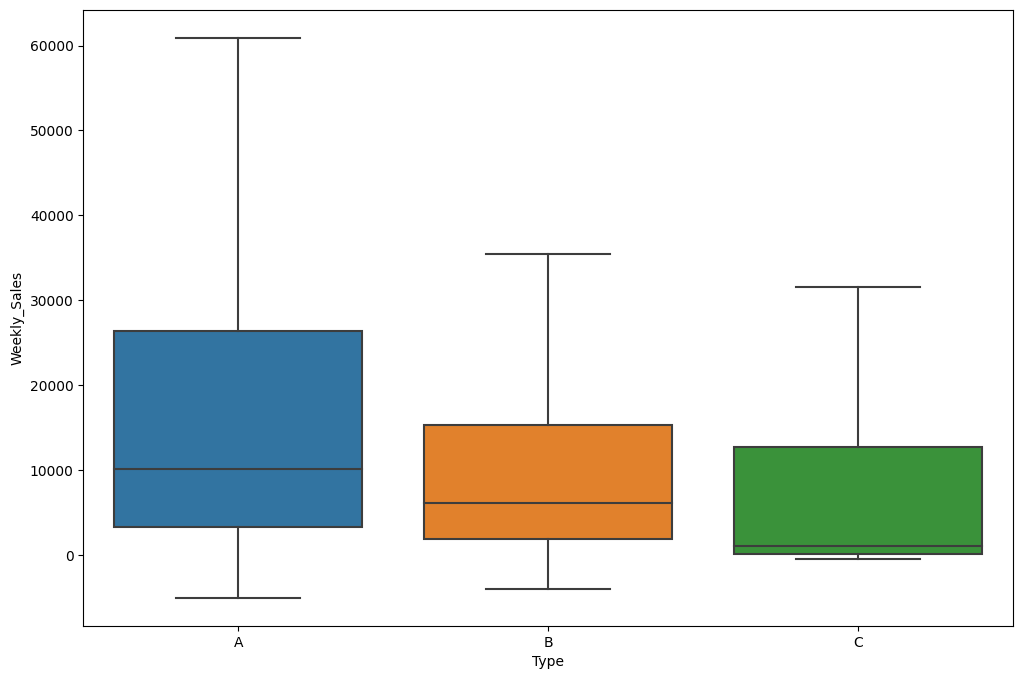

In [12]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)


Impact of holidays on weekly sales

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

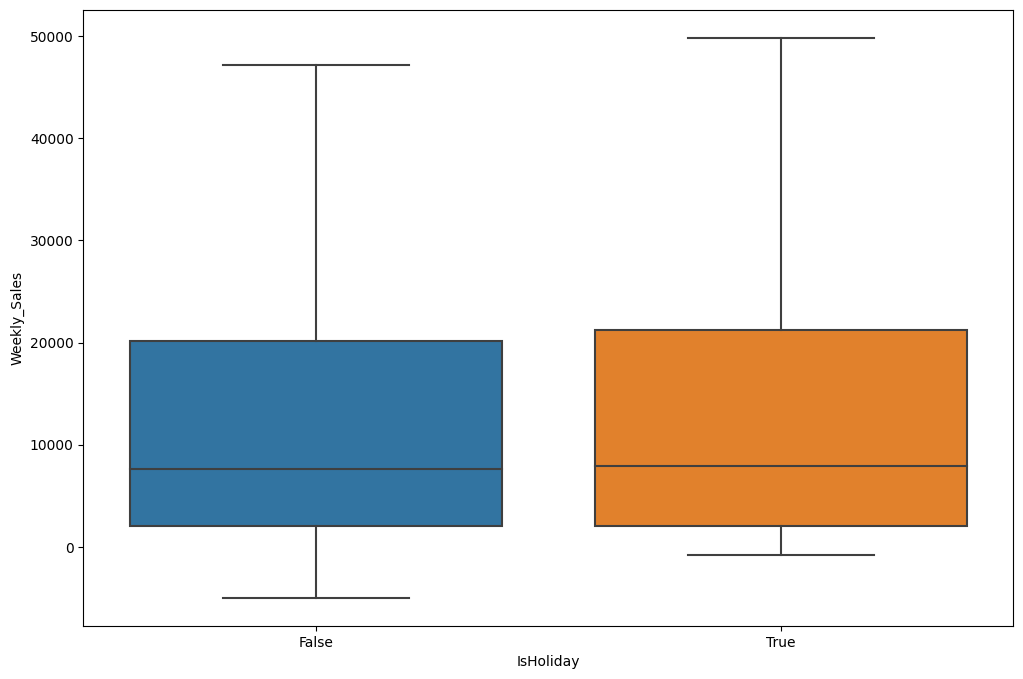

In [13]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'IsHoliday', y ='Weekly_Sales', data = df, showfliers = False)


<Axes: >

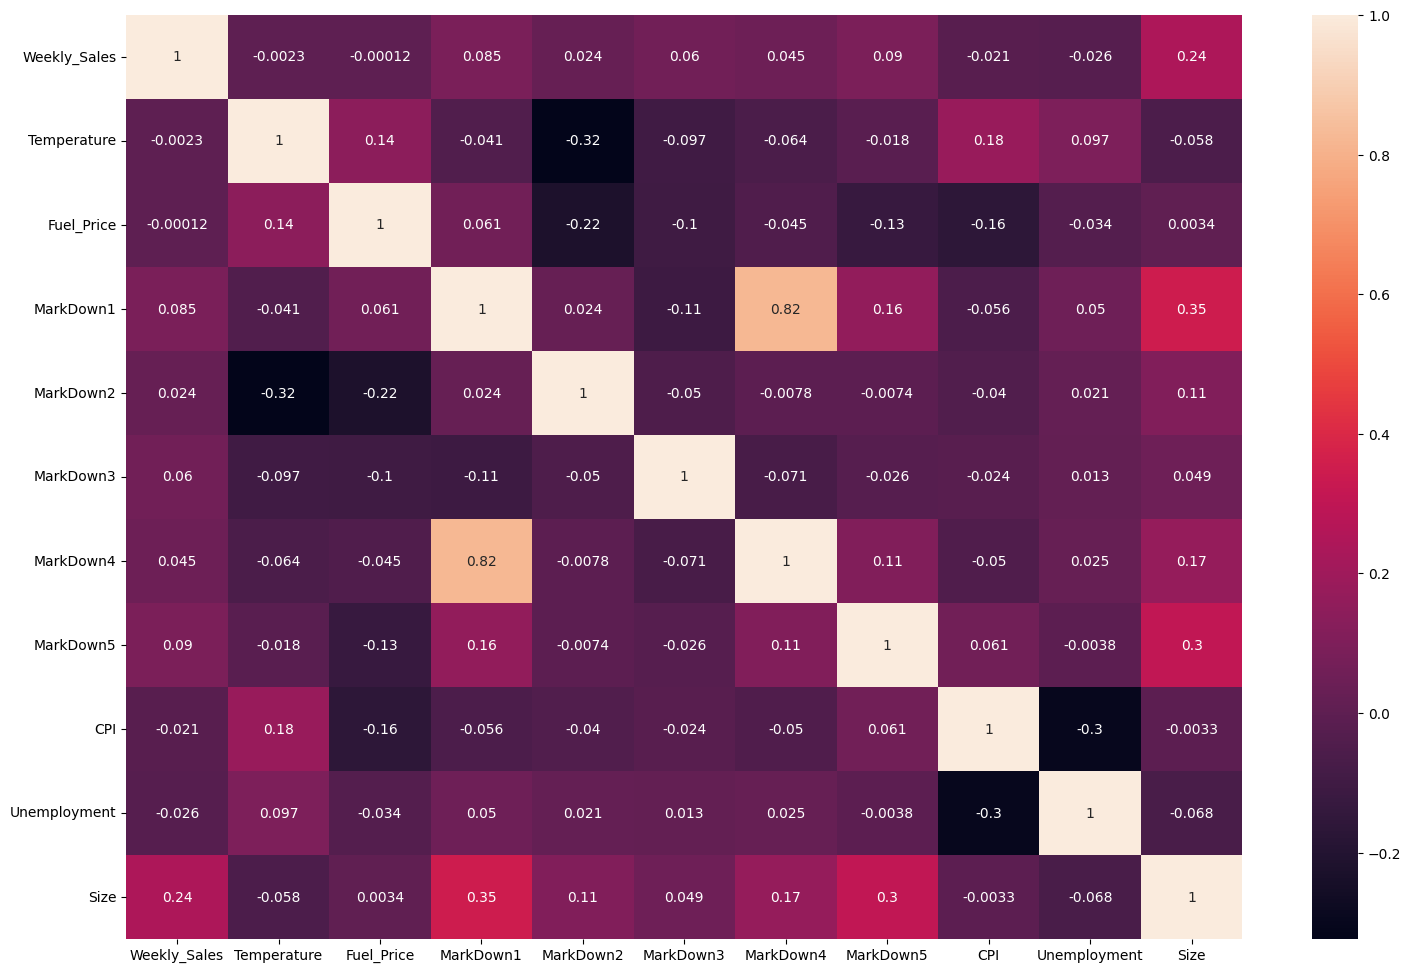

In [14]:
feature_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size']
plt.figure(figsize = (18,12))
sns.heatmap(df[feature_cols].corr(), annot = True)


In [15]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


#4.Data Preprocessing

In [16]:
# Impute NULL values
df['MarkDown1'] = df['MarkDown1'].fillna(0)
df['MarkDown2'] = df['MarkDown2'].fillna(0)
df['MarkDown3'] = df['MarkDown3'].fillna(0)
df['MarkDown4'] = df['MarkDown4'].fillna(0)
df['MarkDown5'] = df['MarkDown5'].fillna(0)
# one hot encoding
cols_to_encode = ['Type', 'IsHoliday']
df = pd.get_dummies(data = df, columns = cols_to_encode, drop_first = True)
#standard scaler
standard_scaler = StandardScaler()
feature_cols = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
transformed_features = standard_scaler.fit_transform(df[feature_cols])




In [17]:
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_B,Type_C,IsHoliday_True
0,1,1,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,0,0,0
1,1,1,2010-02-12,46039.49,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,0,0,1
2,1,1,2010-02-19,41595.55,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,0,0,0
3,1,1,2010-02-26,19403.54,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,0,0,0
4,1,1,2010-03-05,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,0,0,0


In [18]:
# Impute NULL values
test['MarkDown1'] = test['MarkDown1'].fillna(0)
test['MarkDown2'] = test['MarkDown2'].fillna(0)
test['MarkDown3'] = test['MarkDown3'].fillna(0)
test['MarkDown4'] = test['MarkDown4'].fillna(0)
test['MarkDown5'] = test['MarkDown5'].fillna(0)
# one hot encoding
cols_to_encode = ['Type', 'IsHoliday']
test = pd.get_dummies(data = test, columns = cols_to_encode, drop_first = True)
#Standard scalar
standard_scaler = StandardScaler()
feature_cols = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
transformed_features = standard_scaler.fit_transform(df[feature_cols])


In [19]:
test.head()

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_B,Type_C,IsHoliday_True
0,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,151315,0,0,0
1,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,151315,0,0,0
2,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,151315,0,0,0
3,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,151315,0,0,1
4,1,1,2012-11-30,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,151315,0,0,0


In [20]:
X=df.drop(columns=["Date","Weekly_Sales"])
y=df.Weekly_Sales

In [21]:
feature_cols  = df.columns.tolist()
feature_cols = [i for i in feature_cols if i not in ['Date', 'Weekly_Sales']]
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['Weekly_Sales'], test_size = 0.2, random_state = 1234)

#5.Data Modelling 

In [22]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MAE is --> {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is --> {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 score is --> {r2_score(y_pred, y_test)}')


MAE is --> 9767.590626088195
RMSE is --> 16896.41670280314
R2 score is --> 0.04446008465515994


In [23]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred =model.predict(X_test)

print(f'MAE is --> {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is --> {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 Score is --> {r2_score(y_pred, y_test)}')


MAE is --> 2356.9635325094296
RMSE is --> 6791.872299147929
R2 Score is --> 0.909858775661397


In [24]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MAE is --> {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is --> {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 Score is --> {r2_score(y_pred, y_test)}')


MAE is --> 3229.173736769088
RMSE is --> 6517.960691232277
R2 Score is --> 0.9056337472063858


In [25]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MAE is --> {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE is --> {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 Score is --> {r2_score(y_pred, y_test)}')


MAE is --> 1829.5870151979502
RMSE is --> 5425.267272234139
R2 Score is --> 0.9394550071947213


<Axes: xlabel='Weekly_Sales'>

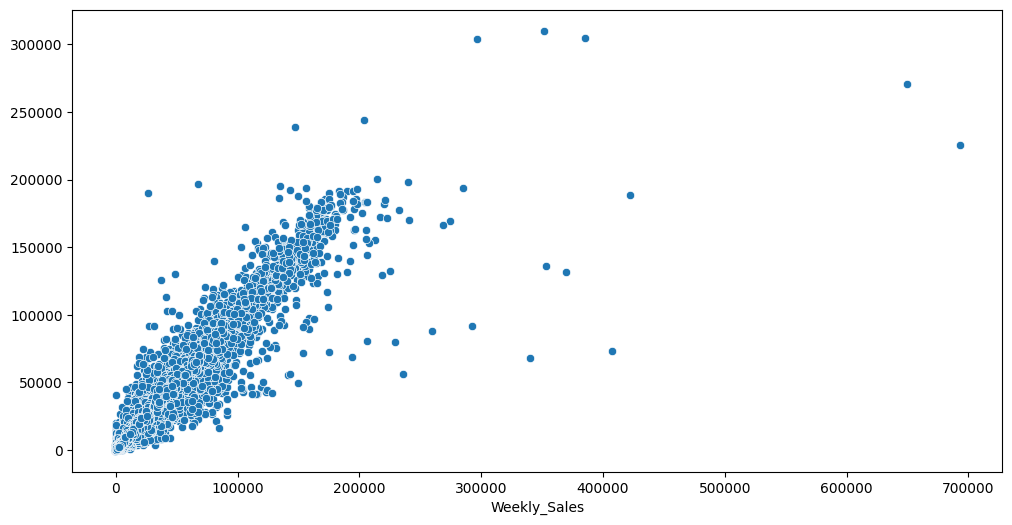

In [26]:
# scatter plot between observed and predicted values of weekly sales from randomforest regressor
plt.figure(figsize = (12,6))
sns.scatterplot(x = y_test, y = y_pred)


In [27]:
#RandomForestRegressor gives the maximum r2score and less mean absolute error and mean squared error

#5.Model fitting and Evaluation

In [28]:
df.isnull().sum()

Store             0
Dept              0
Date              0
Weekly_Sales      0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Size              0
Type_B            0
Type_C            0
IsHoliday_True    0
dtype: int64

In [29]:
test['CPI'].fillna(test['CPI'].mean(),inplace=True)
test['Unemployment'].fillna(test['Unemployment'].mean(),inplace=True)

In [30]:
X2=test.drop(columns=["Date"])

In [31]:
X2.isnull().sum()

Store             0
Dept              0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Size              0
Type_B            0
Type_C            0
IsHoliday_True    0
dtype: int64

In [32]:
rf=RandomForestRegressor()

In [33]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [34]:
y_valid=rf.predict(X2)

In [35]:
test["Weekly_sales"]=y_valid

In [36]:
test.head()

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_B,Type_C,IsHoliday_True,Weekly_sales
0,1,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,151315,0,0,0,25102.6699
1,1,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,151315,0,0,0,22592.0517
2,1,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,151315,0,0,0,26346.8163
3,1,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,151315,0,0,1,37942.1762
4,1,1,2012-11-30,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,151315,0,0,0,33970.1471
